<a href="https://colab.research.google.com/github/8erberg/spatially-embedded-RNN/blob/main/seRSNN_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# seRSNN: How to spatially-embed a recurrent spiking neural network

In this notebook, we demonstrate how to spatially-embed a recurrent spiking neural network and train it on a classic neuromorphic classification task for spiking models. We hope to provide this framework, which applies biologically-inspired spatial and communicability constraints to RSNNs, for open-access use by researchers in the field.

**This notebook was created by Andrew Ham & Danyal Akarca.**


**The following packages were used to build the demo:**

torch: 2.4.1+cu121,

snntorch: 0.6.1,

numpy: 1.24.3,

scipy: 1.13.1,

tonic: 1.2.5,

matplotlib: 3.7.1,

seaborn: 0.13.1,

pandas: 2.1.4,

networkx: 3.3

In [ ]:
#Install packages -----

'''
snnTorch is a package that provides gradient-based learning for spiking neural networks and integrates various spiking neuron models with the PyTorch framework.
Tonic is a package designed specifically for downloading, extracting, and manipulating various neuromorphic datasets.
'''

!pip install -q 'snntorch == 0.6.1'
!pip install -q 'tonic == 1.2.5'

In [ ]:
#Import packages -----

import torch, torch.nn as nn
from torch.utils.data import DataLoader

import snntorch as snn
from snntorch import surrogate
import snntorch.functional as SF

import numpy as np

import scipy
from scipy.stats import pearsonr

import tonic
import tonic.transforms as transforms
from tonic import DiskCachedDataset

import random

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import seaborn as sns
import pandas as pd

import networkx as nx

In [ ]:
#Set random seeds -----

np.random.seed(211)
random.seed(211)
torch.manual_seed(211)

##Preparing the DVS Gesture dataset

The following code downloads and extracts the DVS128 Gesture dataset provided by IBM (https://research.ibm.com/interactive/dvsgesture/). Manipulations of the dataset are possible as desired through Tonic and torchvision.

In [ ]:
#Download and extract DVS Gesture dataset -----

'''
Downloading and extracting the dataset will take approximately 5 minutes.
'''

#Define variables (batch size, sensor size)
batch_size = 64
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
sensor_size = tonic.datasets.DVSGesture.sensor_size

#Define transformations
frame_transform = transforms.Compose([transforms.ToFrame(sensor_size=sensor_size, n_time_bins = 20), transforms.DropEvent(p = 0.001)])

#Define training and test sets
DVS_train = tonic.datasets.DVSGesture(save_to='./data', transform=frame_transform, train=True)
DVS_test = tonic.datasets.DVSGesture(save_to='./data', transform=frame_transform, train=False)

#Create dataloaders
trainloader = DataLoader(DVS_train, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle = True, drop_last = True)
testloader = DataLoader(DVS_test, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle = True, drop_last = True)

## Initializing membrane time constants

As in Perez-Nieves et al. ([2021](https://www.nature.com/articles/s41467-021-26022-3)), membrane time constants are heterogeneously initialized with a random gamma distribution and constrained within a biologically-realistic range.

In [ ]:
#Initialize membrane time constant distribution -----

'''
This section defines two functions: a clipping function and an initialization function. Membrane parameters are taken from Perez-Nieves et al. in order to standardize network comparisons.
'''

#Membrane parameters
tau_mem = 20e-3
dist_shape = 3
time_step = 0.5e-3

#Clipping function
def clip_tc(x):
    clipped_tc = x.clamp_(0.7165, 0.995)
    return clipped_tc

#Initialize membrane time constant distribution
def init_tc():
    dist_gamma = np.random.gamma(dist_shape, tau_mem / 3, 100)
    dist_beta = torch.from_numpy(np.exp(-time_step / dist_gamma))
    clipped_beta = clip_tc(dist_beta)
    return clipped_beta

##Model architecture

We define the recurrent spiking neural network in this section. The snnTorch package is used to instantiate unit neurons as recurrent LIF models (for the hidden layer) and LIF models (for the readout layer). PyTorch is used to create the linear connections between layers.

In [ ]:
#Model architecture -----

'''
self.lif1, which defines the recurrent layer, uses snn.RLeaky to instantiate recurrent LIF neurons, and the parameter learn_beta is set to True to allow time constants to be learnable and updated alongside weights and biases.
'''

#Size parameters
num_inputs = 128*128*2
num_hidden = 100
num_outputs = 11

#Network parameters
het_tau = init_tc().to(device)
hom_tau = 0.9753

#Optimization mechanism
spike_grad = surrogate.fast_sigmoid(slope = 100)

#Model definition
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        #Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.RLeaky(beta = het_tau, linear_features = num_hidden, learn_beta = True, spike_grad = spike_grad)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta = hom_tau, spike_grad = spike_grad)

    def forward(self, x):

        #Initialize parameters
        spk1, mem1 = self.lif1.init_rleaky()
        mem2 = self.lif2.init_leaky()

        #Record output layer
        spk_out_rec = []
        mem_out_rec = []

        #Forward loop
        for step in range(data.size(0)):
            batched_data = data[step].view(batch_size, num_inputs)
            cur1 = self.fc1(batched_data)
            spk1, mem1 = self.lif1(cur1, spk1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            spk_out_rec.append(spk2)
            mem_out_rec.append(mem2)

        #Convert output lists to tensors
        spk_out_rec = torch.stack(spk_out_rec)
        mem_out_rec = torch.stack(mem_out_rec)

        return spk_out_rec, mem_out_rec

net = Net().to(device)

In [ ]:
#Extract membrane time constants (pre-training) -----

'''
The random initialization of time constants is saved pre-training in order to make comparisons to time constant distributions after each epoch of training.
'''

tc_hist = []
pretrain_tau = (-time_step / np.log(het_tau.cpu())) / 1e-3
tc_hist.append(pretrain_tau.numpy())

In [ ]:
#Optimizer and loss function -----

'''
This demonstration uses the Adam optimizer with basic hyperparameters.
The loss is the mean square error spike count loss, a snnTorch function that calculates the total spike count of each neuron and calculates the MSE loss against target spike counts.
'''

optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3, betas = (0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate = 0.8, incorrect_rate = 0.2)

##Creating the Euclidean matrix

This section creates the Euclidean distance matrix for spatial embedding. Weights between hidden layer units are weighted by the distance between them in this defined 3D space.

In [ ]:
#Distance matrix -----
network_structure = [5, 5, 4]
distance_metric = 'euclidean'
distance_power = 1

#Define each dimension's neurons
nx = np.arange(network_structure[0])
ny = np.arange(network_structure[1])
nz = np.arange(network_structure[2])

#Create coordinate grid
[x,y,z] = np.meshgrid(nx,ny,nz)
coordinates = [x.ravel(),y.ravel(),z.ravel()]

#Calculate Euclidean distance matrix
euclidean_vector = scipy.spatial.distance.pdist(np.transpose(coordinates), metric=distance_metric)
euclidean = scipy.spatial.distance.squareform(euclidean_vector**distance_power)
distance_matrix = euclidean.astype('float64')

#Create tensor from distance matrix
distance_matrix = torch.from_numpy(distance_matrix).to(device)

##Validation of spatial embedding

In this section we define a function that will correlate the recurrent weight and distance matrices to validate our method of spatial embedding. If successful, spatial embedding should produce a negative correlation between the two matrices.

In [ ]:
#Diagnostic tests -----

#Test for spatial regularization
def test_euclidean(x, y):
    x = torch.abs(x)
    x_array = x.detach().cpu().numpy()
    flat_x_array = x_array.flatten()
    y = torch.abs(y)
    y_array = y.detach().cpu().numpy()
    flat_y_array = y_array.flatten()
    correlation = pearsonr(flat_x_array, flat_y_array)[0]
    return correlation

print(f"Initial, pre-training correlation between distance and weight matrices (should be approx. 0): {test_euclidean(distance_matrix, net.lif1.recurrent.weight)}")

Initial, pre-training correlation between distance and weight matrices (should be approx. 0): -0.007202817173193758


##Model training

In each training loop, communicability and spatial regularization are applied to the absolute recurrent weight matrix and returned as part of the loss. This regularization is weighted by the term regu_strength.

In [ ]:
'''
Spatial and communicability regularization is applied to standard L1 regularization in the training process.
The communicability term used here is unbiased weighted communicability:
Crofts, J. J., & Higham, D. J. (2009). A weighted communicability measure applied to complex brain networks. Journal of the Royal Society Interface, 6(33), 411-414.
'''

#Training parameters
num_epochs = 50
comms_factor = 1

#Regularization parameters
regu_strength = 0.5e-1

#Initialize variables of interest
train_loss_hist = []
train_acc_hist = []
rec_tot_hist = []
corr_hist = []
test_acc_hist = []
test_loss_hist = []
weight_matrix = []

#Pre-training extractions -- calculate correlation (distance, weights) and total weights before training
rec_tot_hist.append(torch.sum(torch.abs(net.lif1.recurrent.weight.detach())))
corr_hist.append(test_euclidean(distance_matrix, net.lif1.recurrent.weight))

#Training loop
for epoch in range(1, num_epochs + 1):
    for i, (data, targets) in enumerate(iter(trainloader)):
        # Load data on CUDA
        data = data.to(device)
        targets = targets.to(device)

        # Set model to training mode
        net.train()
        spk_outputs, mem_outputs = net(data)

        # Create absolute weight matrix (don't detach)
        abs_weight_matrix = torch.abs(net.lif1.recurrent.weight)

        # Calculate communicability (detach to prevent complex gradient issues)
        with torch.no_grad():
            step1 = torch.sum(abs_weight_matrix, dim=1)
            step2 = torch.pow(step1, -0.5)
            step3 = torch.diag(step2)
            step4 = torch.linalg.matrix_exp(step3 @ abs_weight_matrix @ step3)
            comms_matrix = step4.fill_diagonal_(0)
            comms_matrix = comms_matrix ** comms_factor

        # Calculate regularization term
        regularization_term = torch.sum(abs_weight_matrix * distance_matrix * comms_matrix.detach())

        # Calculate total loss
        task_loss = loss_fn(spk_outputs, targets)
        loss_val = task_loss + regu_strength * regularization_term

        # Gradient calculation and weight updates
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        clip_tc(net.lif1.beta.detach())

        # Store loss history
        train_loss_hist.append(loss_val.item())

    #Evaluations (every epoch)
    net.eval()

    #Training accuracy
    acc = SF.accuracy_rate(spk_outputs, targets)
    train_acc_hist.append(acc)

    #Sum of regularized weights
    rec_tot = torch.sum(torch.abs(net.lif1.recurrent.weight.detach()))
    rec_tot_hist.append(rec_tot)

    #Correlation of distance and weight matrices
    corr_matrix = test_euclidean(distance_matrix, net.lif1.recurrent.weight.detach())
    corr_hist.append(corr_matrix)

    #Save membrane time constant matrix
    converted_tc = (-time_step / np.log(net.lif1.beta.cpu().detach())) / 1e-3
    tc_hist.append(converted_tc.numpy())

    #Save weight matrix
    weight_matrix.append(net.lif1.recurrent.weight.detach().cpu())

    #Validation accuracy
    with torch.no_grad():
        net.eval()
        total = 0
        correct = 0

        for data, targets in testloader:
            data = data.to(device)
            targets = targets.to(device)

            test_spk, test_mem = net(data)

            _, predicted = test_spk.sum(dim=0).max(1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            test_loss = loss_fn(test_spk, targets) + regu_strength * regularization_term

        test_acc_hist.append(correct / total)
        test_loss_hist.append(test_loss.item())

    #Print statements
    #if epoch % 5 == 0:
    print(f"Epoch {epoch}/{num_epochs} === Train loss: {loss_val.item():.2f} --- ", end = "")
    print(f"Train accuracy: {acc * 100:.2f}% --- ", end = "")
    print(f"Val. loss: {test_loss.item():.2f} --- ", end = "")
    print(f"Val. accuracy: {100 * correct / total:.2f}% --- ", end = "")
    print(f"Regularization term: {regularization_term.item():.4f}")

Epoch 1/50 === Train loss: 3.95 --- Train accuracy: 17.19% --- Val. loss: 3.91 --- Val. accuracy: 14.84 --- Regularization term: 25.0987
Epoch 2/50 === Train loss: 2.64 --- Train accuracy: 17.19% --- Val. loss: 2.62 --- Val. accuracy: 23.83 --- Regularization term: 18.9248
Epoch 3/50 === Train loss: 1.88 --- Train accuracy: 29.69% --- Val. loss: 1.86 --- Val. accuracy: 27.73 --- Regularization term: 12.9954
Epoch 4/50 === Train loss: 1.22 --- Train accuracy: 46.88% --- Val. loss: 1.28 --- Val. accuracy: 33.20 --- Regularization term: 7.2074
Epoch 5/50 === Train loss: 0.64 --- Train accuracy: 50.00% --- Val. loss: 0.70 --- Val. accuracy: 40.23 --- Regularization term: 1.5191
Epoch 6/50 === Train loss: 0.51 --- Train accuracy: 60.94% --- Val. loss: 0.57 --- Val. accuracy: 48.44 --- Regularization term: 0.6501
Epoch 7/50 === Train loss: 0.46 --- Train accuracy: 48.44% --- Val. loss: 0.50 --- Val. accuracy: 41.80 --- Regularization term: 0.1408
Epoch 8/50 === Train loss: 0.43 --- Train acc

##Data visualizations

In this section we create basic plots summarizing the trained model's training and validation performance, total weight, and the correlation between weights and unit distances over the 50 epochs.

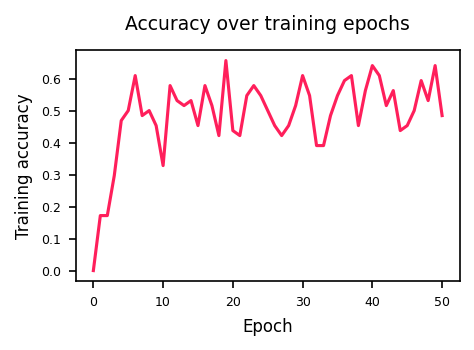

In [ ]:
#Training accuracy
plt.figure(figsize=(3.3,2),dpi=150)
train_acc_hist.insert(0, 0)
plt.plot(train_acc_hist, color = '#ff1f5b')
plt.xlabel('Epoch', fontsize = 8)
plt.ylabel('Training accuracy', fontsize = 8)
plt.tick_params(axis='both', labelsize=6)
plt.title('Accuracy over training epochs', fontsize = 9, pad = 10);

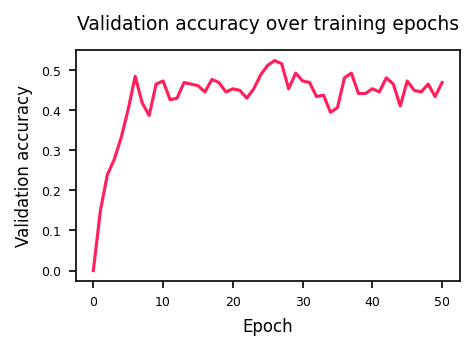

In [ ]:
#Validation accuracy
plt.figure(figsize=(3.3,2),dpi=150)
test_acc_hist.insert(0,0)
plt.plot(test_acc_hist, color = '#ff1f5b')
plt.xlabel('Epoch', fontsize = 8)
plt.ylabel('Validation accuracy', fontsize = 8)
plt.tick_params(axis='both', labelsize=6)
plt.title('Validation accuracy over training epochs', fontsize = 9, pad = 10);

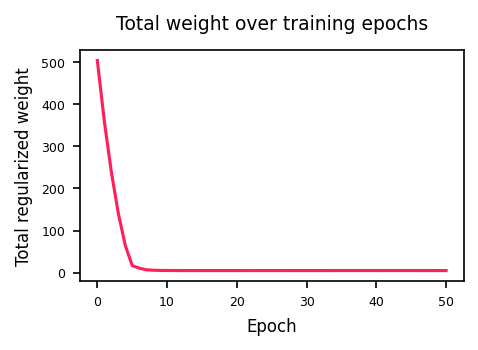

In [ ]:
#Total recurrent weight

'''
The sum of regularized weights decreases over training epochs, demonstrating the effect of spatial and communicability regularization.
'''

rec_tot_hist = torch.FloatTensor(rec_tot_hist)
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(rec_tot_hist.cpu(), color = '#ff1f5b')
plt.xlabel('Epoch', fontsize = 8)
plt.ylabel('Total regularized weight', fontsize = 8)
plt.tick_params(axis='both', labelsize=6)
plt.title('Total weight over training epochs', fontsize = 9, pad = 10);

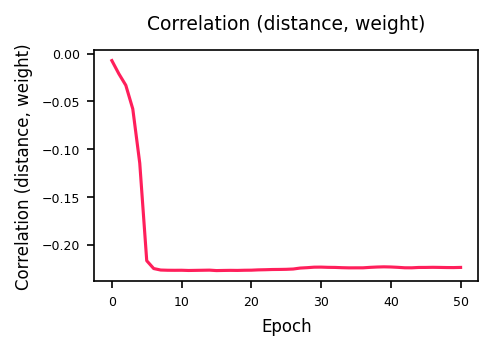

In [ ]:
#Correlation of distance/weight matrices

'''
The correlation between weights and distances decreases (indicating that longer distances will be incentivized to decrease their weights, and vice versa) over training, initially decreasing rapidly and recovering to approximately -0.3.
'''

plt.figure(figsize=(3.3,2),dpi=150)
corr_hist = torch.FloatTensor(corr_hist)
plt.plot(corr_hist.cpu(), color = '#ff1f5b')
plt.xlabel('Epoch', fontsize = 8)
plt.ylabel('Correlation (distance, weight)', fontsize = 8)
plt.tick_params(axis='both', labelsize=6)
plt.title('Correlation (distance, weight)', fontsize = 9, pad = 10);

##Example analysis of modularity
We demonstrate how to conduct analyses of the model structure/topology over the course of training. Here we focus just on the modularity

Final modularity of the network: 0.9789859300040572



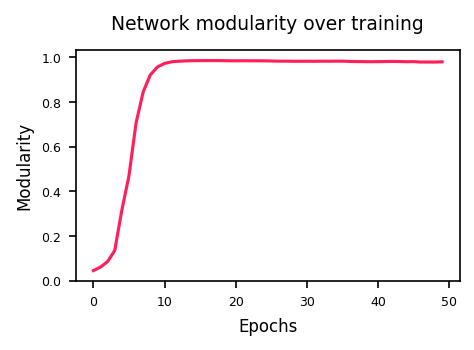

In [ ]:
#Calculate modularity of model after each epoch

'''
Network modularity increases monotonically over training
'''
import networkx as nx
mods = []

for epoch in range(0, num_epochs):
  a = weight_matrix[epoch]
  b = a.cpu().detach().numpy()
  c = np.abs(b)
  g = nx.from_numpy_array(c, create_using=nx.DiGraph)
  communities = nx.community.louvain_communities(g)
  q_stat = nx.community.modularity(g, communities)
  mods.append(q_stat)
print(f'Final modularity of the network: {mods[49]}\n')

#Plot modularity
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(mods, color = '#ff1f5b')
plt.xlabel('Epochs', fontsize = 8)
plt.ylabel('Modularity', fontsize = 8)
plt.tick_params(axis='both', labelsize=6)
plt.title('Network modularity over training', fontsize = 9, pad = 10);